# BINGO CELL IMG CLASSIFICATION

### GPU check

In [40]:
from tensorflow.python.client import device_lib
# device_lib.list_local_devices()

### Import Libraries ＆ First Setup

In [41]:
import matplotlib.pyplot as plt
import datetime
from keras.utils.vis_utils import plot_model
from keras_preprocessing.image import ImageDataGenerator
import tensorflow as tf
import os
import time
import random
import numpy as np
import glob
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')

### 乱数固定

In [42]:
def fix_seed(seed=200):
    tf.random.set_seed(seed)

    # optional
    # for numpy.random
    np.random.seed(seed)
    
    # for built-in random
    random.seed(seed)
    # for hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)


# To avoid "Allocation of X exceeds 10% of free system memory."
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

### About dataset

In [43]:
TRAIN_DATA_DIR = "./train-dataset"
VALID_DATA_DIR = "./valid-dataset"

sum_train_num_files = 0
sum_valid_num_files = 0
for num in range(1, 76):
    train_num_files = len(glob.glob(f'{TRAIN_DATA_DIR}/{num}/*.jpg'))
    valid_num_files = len(glob.glob(f'{VALID_DATA_DIR}/{num}/*.jpg'))
    # print(f"{num}: {train_num_files}, {valid_num_files}")
    sum_train_num_files += train_num_files
    sum_valid_num_files += valid_num_files
print(f"sum: {sum_train_num_files}, {sum_valid_num_files}")

sum: 2338, 375


### Parameters

In [44]:
date_now = str(datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))

# info
SEED = 42
VERBOSE = 1
IMG_SIZE = (40, 40)
MODEL_SAVE_DIR = f"./models/{date_now}"
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

NUM_CLASSES = 75
TRAIN_IMAGES = sum_train_num_files
VALID_IMAGES = sum_valid_num_files

# params
data_generator_param = {
    "rescale": 1 / 256,  # 各ピクセルの値を0以上1以下に正規化(一般的な画像データは256階調で画素の明るさを表現しているから)
    "rotation_range": 5,
    "width_shift_range": 0.15,
    "height_shift_range": 0.15,
    "zoom_range": 0.05,
    "fill_mode": "constant",
    "cval": 255,
}
EPOCHS = 50
TRAIN_BATCHSIZE = 2
VAL_BATCHSIZE = 1

LOSS = 'categorical_crossentropy'
# OPTIMIZER = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
OPTIMIZER = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=None, decay=0.0)
METRICS = 'accuracy'

In [45]:
train_datagen = ImageDataGenerator(**data_generator_param)
valid_datagen = ImageDataGenerator(**data_generator_param)
train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR, 
    target_size=IMG_SIZE, 
    class_mode='categorical',
    batch_size=TRAIN_BATCHSIZE,
    color_mode="rgb",
    shuffle=True,
    seed=SEED,
)
valid_generator = valid_datagen.flow_from_directory(
    VALID_DATA_DIR,
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=VAL_BATCHSIZE,
    color_mode="rgb",
    shuffle=True,
    seed=SEED,
)
test_generator = valid_datagen.flow_from_directory(
    VALID_DATA_DIR,
    target_size=IMG_SIZE,
    class_mode=None,
    batch_size=VAL_BATCHSIZE,
    color_mode="rgb",
    shuffle=False,
    seed=SEED,
)

# ラベル名とインデックスの紐づけ
with open(f"{MODEL_SAVE_DIR}/class_labels.txt", mode="w") as f:
    for value, index in valid_generator.class_indices.items():
        f.write(f"{index} {value}\n")
labels = (train_generator.class_indices)
LABEL_INDICES_DICT = dict((v,k) for k,v in labels.items())


STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

Found 2338 images belonging to 75 classes.
Found 375 images belonging to 75 classes.
Found 375 images belonging to 75 classes.


### Callback

In [46]:
eary_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='auto', baseline=None, min_delta=0.001,)

tensor_board_cb = tf.keras.callbacks.TensorBoard(log_dir=MODEL_SAVE_DIR, histogram_freq=1, write_images=0, write_grads=0, write_graph=0)

fpath = 'weight-{epoch:02d}-{loss:.3f}-{accuracy:.3f}-{val_loss:.3f}-{val_accuracy:.3f}.h5'
model_checkpoint_acc_cb = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(MODEL_SAVE_DIR, fpath), monitor='accuracy', verbose=0, save_best_only=True, mode='auto', save_weights_only=False)
model_checkpoint_loss_cb = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(MODEL_SAVE_DIR, fpath), monitor='loss', verbose=0, save_best_only=True, mode='auto', save_weights_only=False)
model_checkpoint_val_acc_cb = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(MODEL_SAVE_DIR, fpath), monitor='val_accuracy', verbose=0, save_best_only=True, mode='auto', save_weights_only=False)
model_checkpoint_val_loss_cb = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(MODEL_SAVE_DIR, fpath), monitor='val_loss', verbose=0, save_best_only=True, mode='auto', save_weights_only=False)


callbacks = [eary_stopping_cb, tensor_board_cb, model_checkpoint_acc_cb, model_checkpoint_loss_cb, model_checkpoint_val_acc_cb, model_checkpoint_val_loss_cb]

#### Tensorboardの使い方
```
tensorboard --logdir  ./programs/ML/models/
```

### モデルの定義

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 40, 40, 128)       6272      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 20, 20, 128)       262272    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 10, 10, 128)      0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 12800)             0         
                                                                 
 dropout_4 (Dropout)         (None, 12800)            

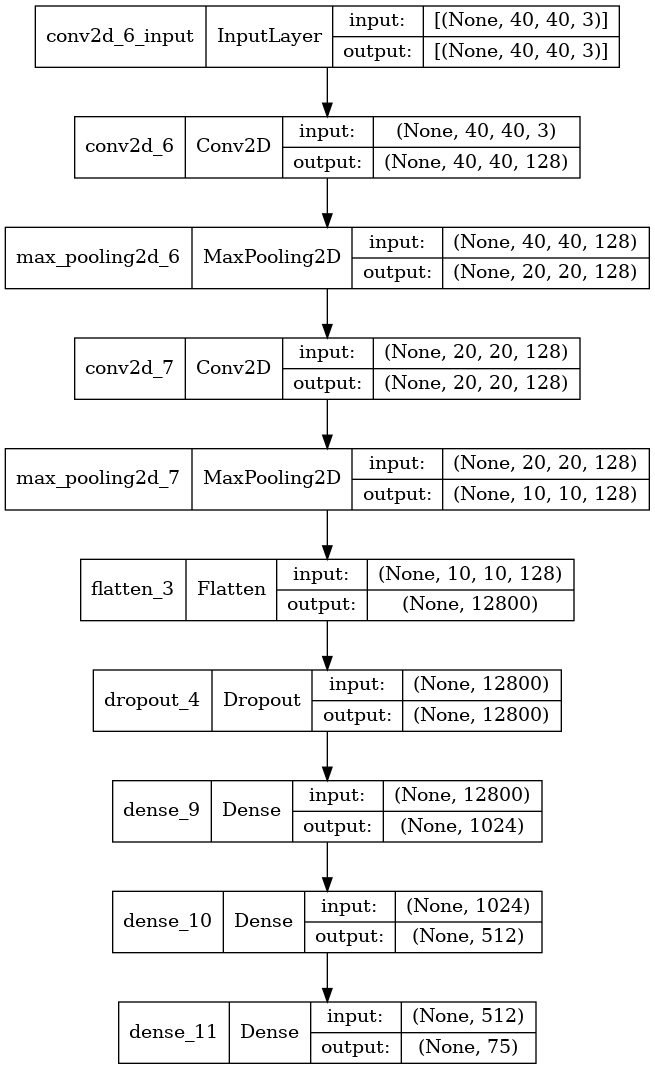

In [47]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(
        128, (4, 4), activation='relu', padding='Same', input_shape=IMG_SIZE+(3,)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (4, 4), activation='relu', padding='Same'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
])
model.summary()

date_now = str(datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
plot_model(model, to_file=f'{MODEL_SAVE_DIR}/' + "NN-model-summary.png", show_shapes=True)

### 学習

In [48]:
fix_seed(SEED)

start_time = time.time()
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=[METRICS])
history = model.fit(train_generator,
                    epochs=EPOCHS,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    verbose=VERBOSE,
                    validation_steps=STEP_SIZE_VALID,
                    callbacks=callbacks,
                    )
print(f"{(time.time()-start_time)/60} min")

Epoch 1/50
1169/1169 [==============================] - 22s 18ms/step - loss: 4.3462 - accuracy: 0.0197 - val_loss: 4.3290 - val_accuracy: 0.0133
Epoch 2/50
1169/1169 [==============================] - 22s 19ms/step - loss: 4.2935 - accuracy: 0.0257 - val_loss: 4.3351 - val_accuracy: 0.0133
Epoch 3/50
1169/1169 [==============================] - 22s 19ms/step - loss: 4.1659 - accuracy: 0.0304 - val_loss: 4.0025 - val_accuracy: 0.0293
Epoch 4/50
1169/1169 [==============================] - 21s 18ms/step - loss: 3.7580 - accuracy: 0.0714 - val_loss: 3.5767 - val_accuracy: 0.0800
Epoch 5/50
1169/1169 [==============================] - 22s 18ms/step - loss: 3.1226 - accuracy: 0.1591 - val_loss: 2.7488 - val_accuracy: 0.2027
Epoch 6/50
1169/1169 [==============================] - 22s 19ms/step - loss: 2.4976 - accuracy: 0.2746 - val_loss: 2.0884 - val_accuracy: 0.3280
Epoch 7/50
1169/1169 [==============================] - 22s 19ms/step - loss: 2.0435 - accuracy: 0.3871 - val_loss: 1.6434 -

### 精度の確認

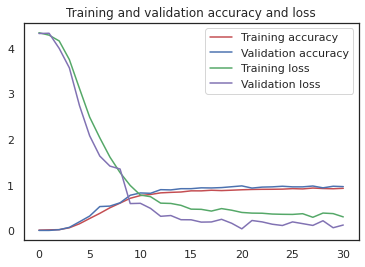

In [49]:
model.save(
    os.path.join(
        MODEL_SAVE_DIR,
        "weight-final.h5"))  # モデルの保存(h5形式)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.plot(epochs, loss, 'g', label="Training loss")
plt.plot(epochs, val_loss, 'm', label="Validation loss")
plt.title('Training and validation accuracy and loss')
plt.legend(loc=0)
plt.savefig(f'{MODEL_SAVE_DIR}/accuracy.png')
plt.show()

375/375 [==============================] - 1s 2ms/step


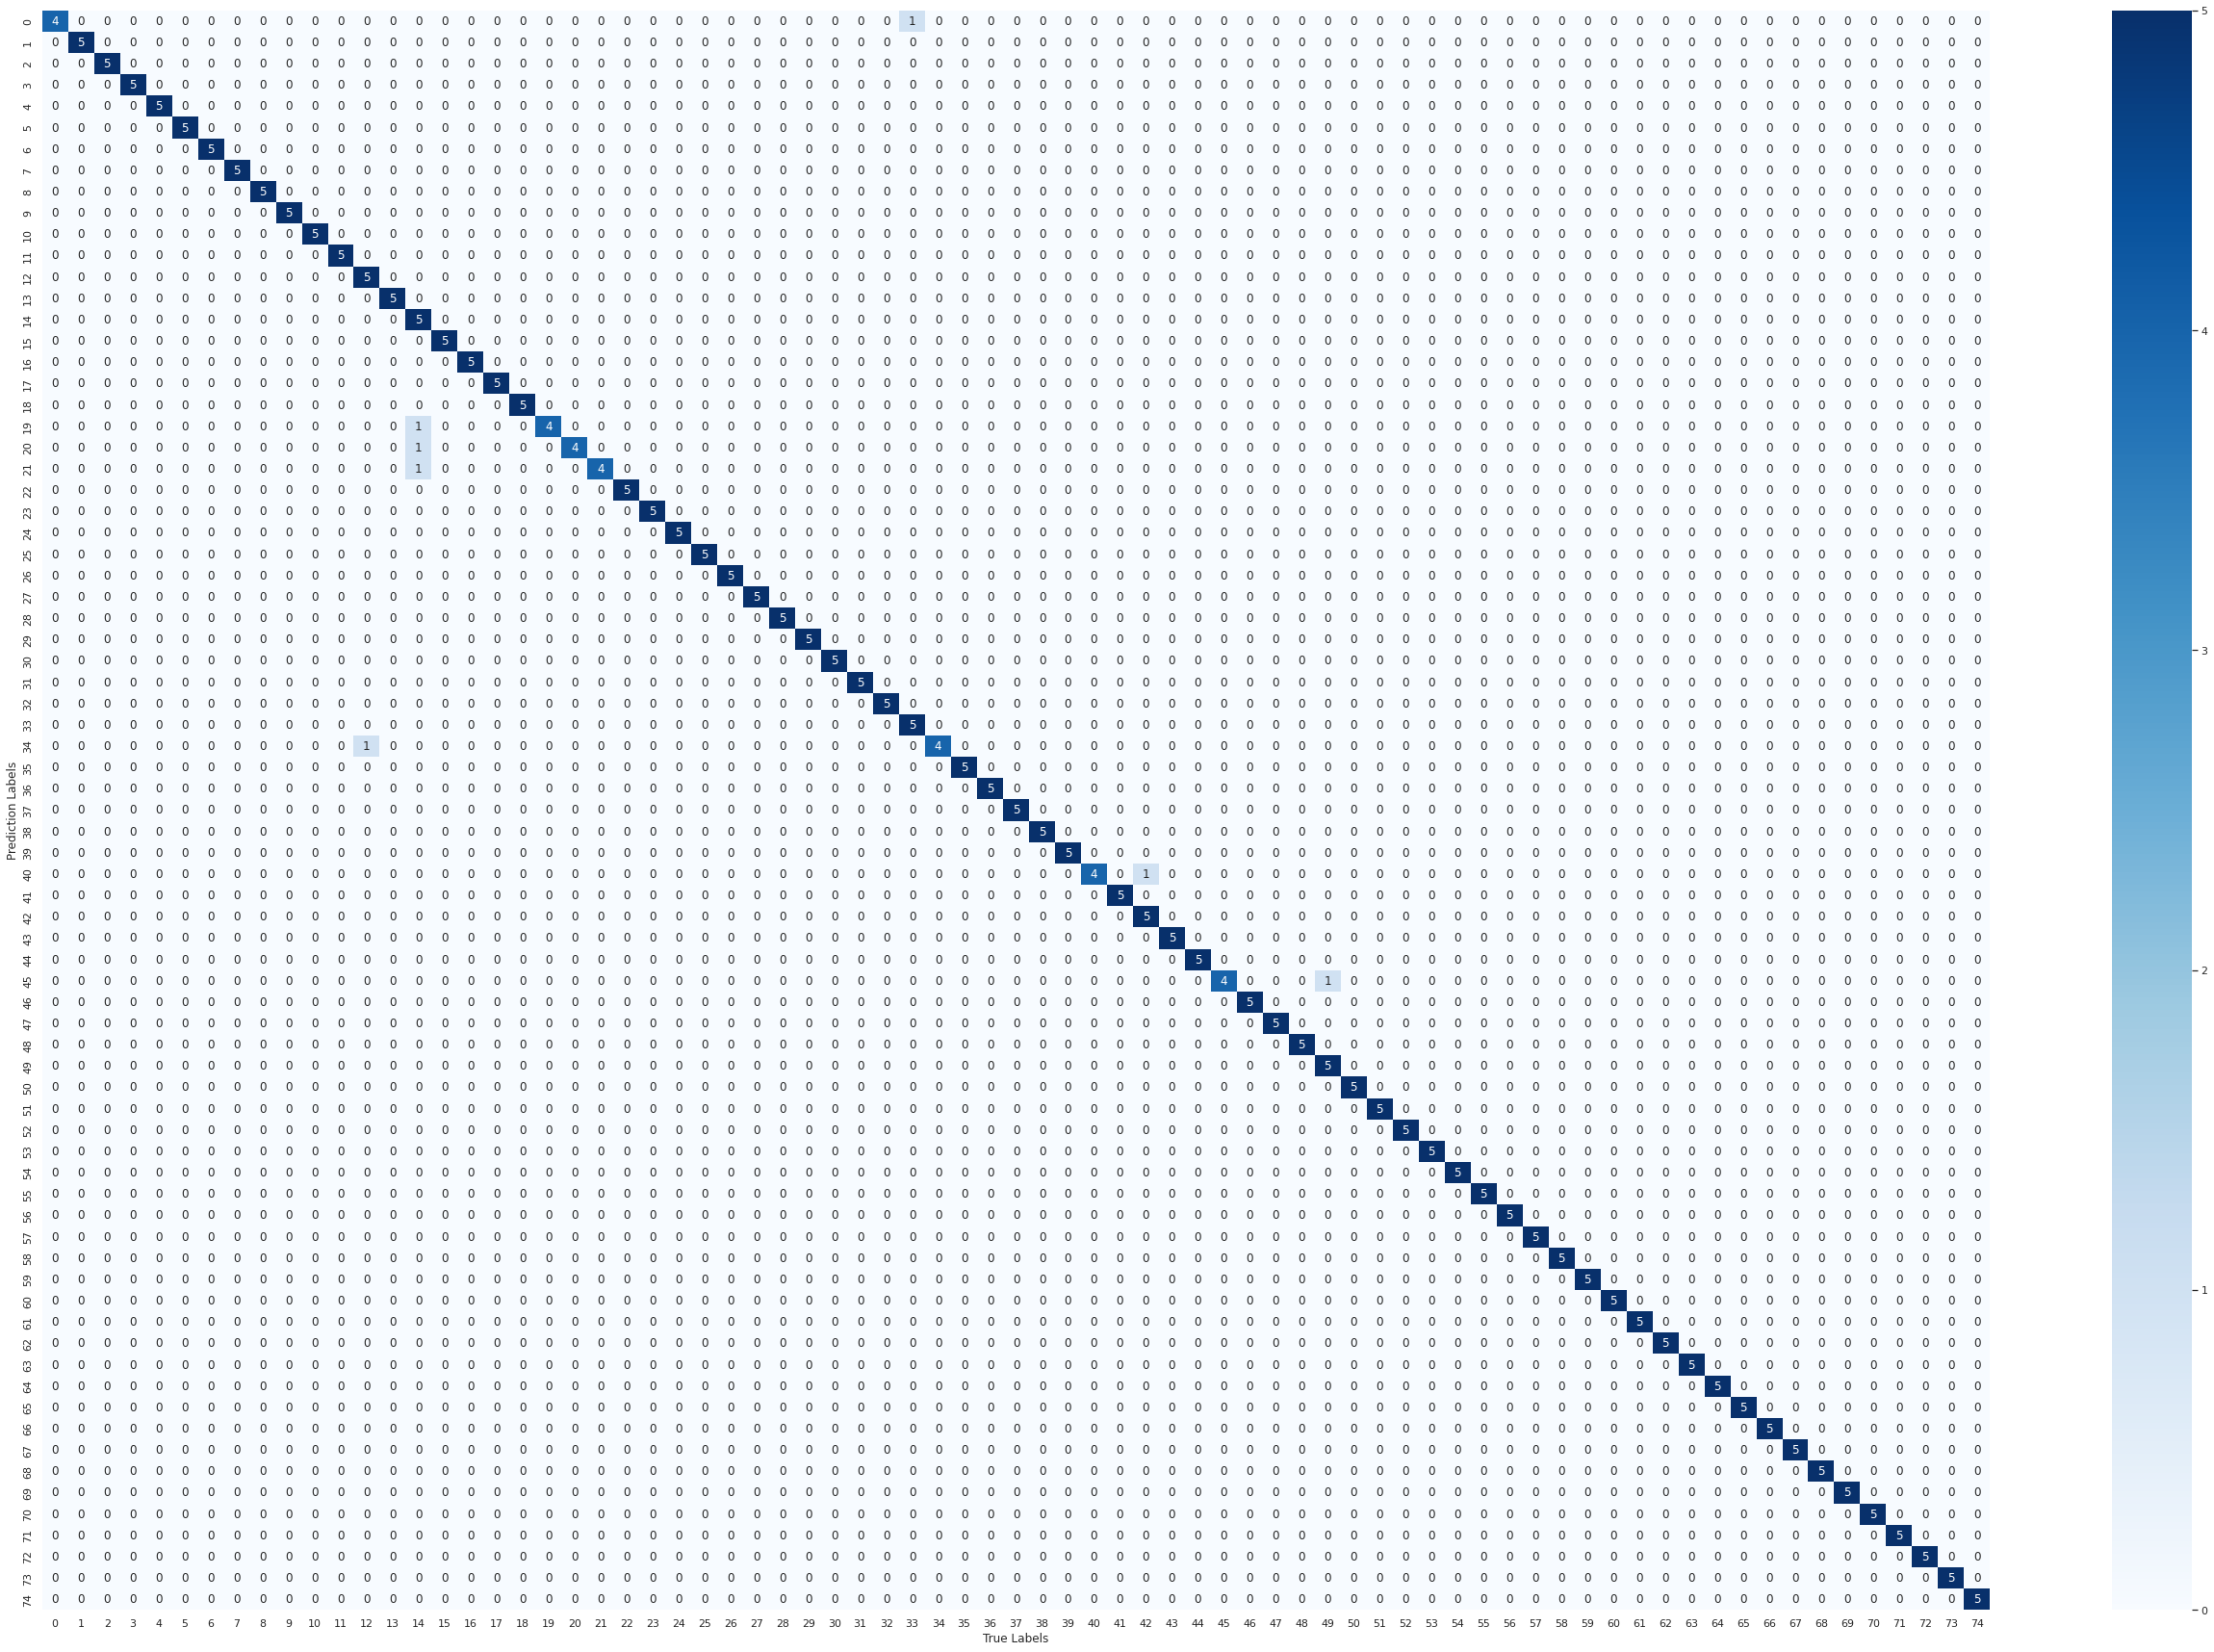

In [50]:
true_label_indicies = test_generator.classes
true_labels = [LABEL_INDICES_DICT[i] for i in true_label_indicies]

prediction_indicies = model.predict(test_generator, steps=STEP_SIZE_TEST, verbose=1)
prediction_indicies = np.argmax(prediction_indicies, axis=1)
predictions = [LABEL_INDICES_DICT[i] for i in prediction_indicies]
confusion_mtx = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(36, 24)) 
sns.heatmap(confusion_mtx, cmap='Blues', annot=True)
plt.xlabel("True Labels")
plt.ylabel("Prediction Labels")
plt.tight_layout()
plt.savefig(f'{MODEL_SAVE_DIR}/confusion_mtx.png')
plt.show()